# Build Movie Recommendation System

[Krish Naik](https://www.youtube.com/watch?v=i4a0Of22QRg)

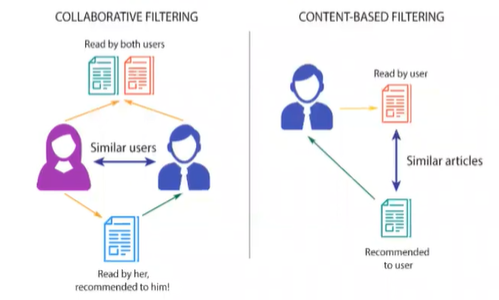

## Connect Kaggle

In [9]:
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# https://www.kaggle.com/tmdb/tmdb-movie-metadata
!kaggle datasets download -d tmdb/tmdb-movie-metadata

  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 81.4MB/s]


In [11]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


## Import Modules

In [12]:
import pandas as pd
import numpy as np

In [13]:
credits_df = pd.read_csv('tmdb_5000_credits.csv')
movies_df = pd.read_csv('tmdb_5000_movies.csv')

In [14]:
credits_df.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [15]:
movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [16]:
print(credits_df.shape)
print(movies_df.shape)

(4803, 4)
(4803, 20)


The credits has movie_id and the movies has id - It can be concatenated

In [19]:
credits_columns_renamed = credits_df.rename(index=str, columns={'movie_id': 'id'})
df_movies_merged = movies_df.merge(credits_columns_renamed, on='id')
df_movies_merged.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Right now there are original_title, title_x and title_y

In [20]:
df_movies_cleaned = df_movies_merged.drop(columns=['homepage', 'title_x', 'title_y', 'status', 'production_countries'])
df_movies_cleaned.head()

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",A Plan No One Escapes,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Legend Ends,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","Lost in our world, found in another.",6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [21]:
df_movies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   release_date          4802 non-null   object 
 10  revenue               4803 non-null   int64  
 11  runtime               4801 non-null   float64
 12  spoken_languages      4803 non-null   object 
 13  tagline               3959 non-null   object 
 14  vote_average          4803 non-null   float64
 15  vote_count           

## Using Weighted Average For Each Movie's Average Rating

### Content Based Recommendation System

Make a recommendations based on the movie's plot summaries given in the overview columns. If user gives a movie title, the goal will give the recommendation with similar plot summaries

In [23]:
df_movies_cleaned.head(1)['overview']

0    In the 22nd century, a paraplegic Marine is di...
Name: overview, dtype: object

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                      ngram_range=(1,3),
                      stop_words = 'english')

# Filling NaNs with empty string
df_movies_cleaned['overview'] = df_movies_cleaned['overview'].fillna('')

In [25]:
df_movies_cleaned['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

In [26]:
# Fitting TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(df_movies_cleaned['overview'])

In [27]:
tfv_matrix

<4803x10417 sparse matrix of type '<class 'numpy.float64'>'
	with 127220 stored elements in Compressed Sparse Row format>

In [28]:
tfv_matrix.shape

(4803, 10417)

In [30]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [31]:
sig[0]

array([0.76163447, 0.76159416, 0.76159416, ..., 0.76159416, 0.76159416,
       0.76159416])

In [34]:
len(sig[0])

4803

In [32]:
indices = pd.Series(df_movies_cleaned.index, index=df_movies_cleaned['original_title']).drop_duplicates()

In [33]:
indices

original_title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [35]:
indices['Newlyweds']

4799

In [36]:
sig[4799]

array([0.76159416, 0.76159416, 0.76159438, ..., 0.76159432, 0.76159416,
       0.76159478])

In [37]:
list(enumerate(sig[indices['Newlyweds']]))

[(0, 0.7615941559557649),
 (1, 0.7615941559557649),
 (2, 0.7615943791623508),
 (3, 0.7615945564232902),
 (4, 0.7615945779342557),
 (5, 0.7615943267971559),
 (6, 0.7615948190414071),
 (7, 0.761594346971664),
 (8, 0.7615943903358866),
 (9, 0.761594688255891),
 (10, 0.7615941559557649),
 (11, 0.7615941559557649),
 (12, 0.7615941559557649),
 (13, 0.7615941559557649),
 (14, 0.7615941559557649),
 (15, 0.7615941559557649),
 (16, 0.7615943548130526),
 (17, 0.761594965420998),
 (18, 0.7615942819944952),
 (19, 0.7615945082445131),
 (20, 0.76159429283816),
 (21, 0.7615949832832597),
 (22, 0.7615941559557649),
 (23, 0.761594428370306),
 (24, 0.7615941559557649),
 (25, 0.7615941559557649),
 (26, 0.7615941559557649),
 (27, 0.7615944537585687),
 (28, 0.7615941559557649),
 (29, 0.7615943053510925),
 (30, 0.7615943361754078),
 (31, 0.76159445046522),
 (32, 0.7615941559557649),
 (33, 0.7615944286938301),
 (34, 0.7615941559557649),
 (35, 0.7615941559557649),
 (36, 0.7615941559557649),
 (37, 0.76159439493

In [42]:
def give_rec(title, sig=sig):
  # Get the index coresponding to original title
  idx = indices[title]

  # Get the pairwise similarity scores
  sig_scores = list(enumerate(sig[idx]))

  # Sort the movies
  sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

  # Scores of the 10 most similar movies
  sig_scores = sig_scores[1:11] # It also skip the input in the output

  # Movie indices
  movie_indices = [i[0] for i in sig_scores]

  # Top 10 most similar movies
  return df_movies_cleaned['original_title'].iloc[movie_indices]

In [41]:
# Testing content-based recommendation system with the spy kids
give_rec('Spy Kids')

1302    Spy Kids 2: The Island of Lost Dreams
1155                  Spy Kids 3-D: Game Over
1769      Spy Kids: All the Time in the World
4044                               Go for It!
3359                              In Too Deep
1631                                 Mr. 3000
1825                Jimmy Neutron: Boy Genius
339                           The Incredibles
3793                     The Velocity of Gary
1081                       Revolutionary Road
Name: original_title, dtype: object

In [43]:
give_rec('Avatar')

1341                Obitaemyy Ostrov
634                       The Matrix
3604                       Apollo 18
2130                    The American
775                        Supernova
529                 Tears of the Sun
151                          Beowulf
311     The Adventures of Pluto Nash
847                         Semi-Pro
942                 The Book of Life
Name: original_title, dtype: object

In [44]:
give_rec('Tangled')

2309                                     逃出生天
39                               TRON: Legacy
330     The Lord of the Rings: The Two Towers
2821          Beavis and Butt-Head Do America
4633                              Death Calls
1984                The Thief and the Cobbler
1059                                 Anaconda
4191                         Against the Wild
4313                               Below Zero
1041                                  Taken 2
Name: original_title, dtype: object